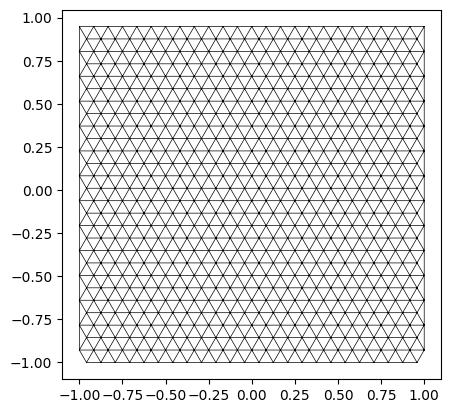

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from enum import Enum
import json
import scipy.sparse as sps
import trimesh
import jax.numpy as jnp

class GridPattern(Enum):
    HEX = 1
    RECT = -1


def edge(a, b):
    return (min(a, b), max(a, b))


class Mesh:
    def __init__(self, vertices=None, faces=None, lazy=False):
        """
        Initialize the Mesh with given vertices and faces.
        If vertices and faces are not provided, it will generate a default mesh.
        """
        if vertices is None or faces is None:
            # Generate default mesh (e.g., unit square grid)
            self.vertices, self.faces = self.generate_default_mesh()
        else:
            self.vertices = np.array(vertices)
            self.faces = np.array(faces)

        self.boundary_mask = self.find_boundary_vertices()
        self.edges = self.compute_edges()
        self.edge_map = self.compute_edge_map()
        self.tri_map = self.compute_tri_map()
        self.opposing_vertices = self.compute_opposing_vertices()
        self.d0 = self.compute_d0()
        self.d1 = self.compute_d1()

        if not lazy:
            self.recompute()

    def recompute(self):
        """
        Recomputes all mesh properties.
        """

        self.areas = self.compute_areas()
        self.lengths = self.compute_edge_lengths()
        self.star0 = self.compute_star0()
        self.star1_circ = self.compute_star1_circ()
        self.star1_bary = self.compute_star1_bary()
        self.laplace_matrix = (
            -np.linalg.inv(self.star0.toarray()) @ self.d0.T @ self.star1_circ @ self.d0
        )

    @staticmethod
    def generate_default_mesh(n=25, gridpattern=GridPattern.HEX):
        """
        Generates a default mesh (rectangular or hexagonal) for testing purposes.
        """
        if gridpattern == GridPattern.RECT:
            x = np.linspace(-1, 1, n)
            z = np.linspace(-1, 1, n)
            xv, zv = np.meshgrid(x, z)
            vertices = np.column_stack((xv.ravel(), np.zeros(n * n), zv.ravel()))
            triang = mtri.Triangulation(vertices[:, 0], vertices[:, 2])
            faces = triang.triangles
        elif gridpattern == GridPattern.HEX:
            # # Generate hexagonal grid
            # x = np.arange(-n, n)
            # z = np.arange(-n, n)
            # xv, zv = np.meshgrid(x, z)
            # xv = xv + (zv % 2) * 0.5
            # xv, zv = xv / n, zv / n
            # vertices = np.column_stack((xv.ravel(), np.zeros(xv.size), zv.ravel()))
            # triang = mtri.Triangulation(vertices[:, 0], vertices[:, 2])
            # faces = triang.triangles

            def get_hex_points(columns):
                long_row = np.linspace(-1, 1, columns)
                dist = 2 / (columns - 1) / 2
                small_row = np.linspace(-1 + dist, 1 - dist, columns - 1)
                height = dist * 2 * np.sqrt(3) / 2
                vertices = []
                borders = []
                rows = int(np.ceil(2 / (height)))
                for row in range(rows):
                    odd = row % 2 == 0
                    height_coord = (-1 + (height * row)) * np.ones_like(
                        small_row if odd else long_row
                    )
                    to_add = np.vstack((small_row if odd else long_row, height_coord)).T
                    vertices.extend(to_add)
                    if row != 0 and row != rows - 1:
                        borders.extend([True] + [False] * (len(to_add) - 2) + [True])
                    else:
                        borders.extend([True] * len(to_add))
                return np.array(vertices), np.array(borders)

            vertices, _border = get_hex_points(n)
            vertices = np.column_stack(
                (vertices[:, 0], np.zeros(vertices.shape[0]), vertices[:, 1])
            )
            triang = mtri.Triangulation(vertices[:, 0], vertices[:, 2])
            faces = triang.triangles

        else:
            raise ValueError("Unknown grid pattern.")
        return vertices, faces

    def compute_edges(self):
        """
        Computes unique edges from faces.
        """
        edges = set()
        for tri in self.faces:
            a, b, c = map(int, tri)
            edges.update(
                {
                    edge(a, b),
                    edge(b, c),
                    edge(c, a),
                }
            )
        return np.array(sorted(edges))

    def compute_edge_map(self):
        """
        Computes a mapping from each vertex to its connected vertices.
        """
        edge_map = [{} for _ in range(len(self.vertices))]
        for a, b in self.edges:
            edge_map[a][b] = True
            edge_map[b][a] = True
        return edge_map

    def compute_tri_map(self):
        """
        Computes a mapping from each vertex to the triangles it belongs to.
        """
        tri_map = [[] for _ in range(len(self.vertices))]
        for i, tri in enumerate(self.faces):
            a, b, c = map(int, tri)
            tri_map[a].append(i)
            tri_map[b].append(i)
            tri_map[c].append(i)
        return tri_map

    def compute_areas(self):
        """
        Computes the area of each triangle using NumPy.
        """
        # Get the coordinates of the triangle vertices
        vertex_coords = self.vertices[self.faces]  # shape (N, 3, D)
        a = vertex_coords[:, 0, :]  # shape (N, D)
        b = vertex_coords[:, 1, :]
        c = vertex_coords[:, 2, :]

        # Compute vectors
        ab = b - a  # shape (N, D)
        ac = c - a  # shape (N, D)

        # Compute cross product
        cross_prod = np.cross(ab, ac)  # shape (N, D)

        # Compute norms of cross product
        norms = np.linalg.norm(cross_prod, axis=1)  # shape (N,)

        # Compute areas
        areas = 0.5 * norms  # shape (N,)

        return areas

    def compute_edge_lengths(self):
        """
        Computes the length of each edge.
        """
        vertices = self.vertices
        edges = self.edges
        lengths = np.linalg.norm(vertices[edges[:, 0]] - vertices[edges[:, 1]], axis=1)
        return lengths

    def compute_d0(self):
        """
        Computes the exterior derivative d0.
        """
        num_edges = len(self.edges)
        num_vertices = len(self.vertices)
        row_indices = []
        col_indices = []
        data = []
        for i, (a, b) in enumerate(self.edges):
            row_indices.extend([i, i])
            col_indices.extend([a, b])
            data.extend([-1, 1])
        d0 = sps.coo_matrix(
            (data, (row_indices, col_indices)), shape=(num_edges, num_vertices)
        )
        return d0

    def compute_d1(self):
        """
        Computes the exterior derivative d1.
        """
        num_faces = len(self.faces)
        num_edges = len(self.edges)
        edge_dict = {e: idx for idx, e in enumerate(map(tuple, self.edges))}
        row_indices = []
        col_indices = []
        data = []
        for i, tri in enumerate(self.faces):
            a, b, c = map(int, tri)
            face_edges = [
                (a, b),
                (b, c),
                (c, a),
            ]
            for u, v in face_edges:
                e = edge(u, v)
                edge_idx = edge_dict[e]
                row_indices.append(i)
                col_indices.append(edge_idx)
                # Determine orientation
                orientation = 1 if (u, v) == e else -1
                data.append(orientation)
        d1 = sps.coo_matrix(
            (data, (row_indices, col_indices)), shape=(num_faces, num_edges)
        )
        return d1

    def compute_star0(self):
        """
        Computes the Hodge star operator on 0-forms, holds the dual areas of each vertex
        """
        areas = self.areas
        tri_map = self.tri_map
        star0_diagonal = np.array(
            [np.sum(areas[np.array(tris)]) / 3.0 for tris in tri_map]
        )
        return sps.diags(star0_diagonal)

    def compute_star1_circ(self):
        A = np.zeros((len(self.edges), len(self.edges)), dtype=float)
        for i in range(len(self.edges)):
            (a, b) = self.edges[i]

            weights = []
            for oppo in self.opposing_vertices[i]:
                c = self.vertices[oppo]
                ca = self.vertices[a] - c
                ca /= np.linalg.norm(ca)
                cb = self.vertices[b] - c
                cb /= np.linalg.norm(cb)
                angle = np.arccos(np.dot(ca, cb))
                weights.append(np.cos(angle) / np.sin(angle))

            A[i, i] = 0.5 * sum(weights)
        return A

    def compute_opposing_vertices(
        self,
    ):
        opposing_vertices = [[] for _ in range(len(self.edges))]
        for i, tri in enumerate(self.faces):
            for j in range(3):
                a, b, c = tri[j], tri[(j + 1) % 3], tri[(j + 2) % 3]
                index = np.where((self.edges == edge(a, b)).all(axis=1))[0][0]
                opposing_vertices[index].append(int(c))
        return opposing_vertices

    def compute_star1_bary(self):
        A = np.zeros((len(self.edges), len(self.edges)), dtype=float)
        for i in range(len(self.edges)):
            (a, b) = self.edges[i]

            barycenters = []
            for oppo in self.opposing_vertices[i]:
                c = self.vertices[oppo]
                barycenter = (self.vertices[a] + self.vertices[b] + c) / 3
                barycenters.append(barycenter)
            if len(barycenters) == 2:
                A[i, i] = (
                    np.linalg.norm(barycenters[0] - barycenters[1]) / self.lengths[i]
                )
            if len(barycenters) == 1:
                mp = (self.vertices[a] + self.vertices[b]) / 2
                A[i, i] = 2 * np.linalg.norm(barycenters[0] - mp) / self.lengths[i]
            else:
                A[i, i] = 1
        return A

    def find_boundary_vertices(self):
        """
        Finds the indices of boundary vertices in a mesh using trimesh.

        Parameters:
        - vertices: numpy array of shape (N, 3), where N is the number of vertices.
        - faces: numpy array of shape (M, 3), where M is the number of faces.

        Returns:
        - boundary_vertex_indices: numpy array of bool indicating whether each vertex is on the boundary.
        """
        # Create a mesh object
        mesh = trimesh.Trimesh(vertices=self.vertices, faces=self.faces, process=False)

        unique_edges = mesh.edges[
            trimesh.grouping.group_rows(mesh.edges_sorted, require_count=1)
        ]
        # get all vertices in this mesh
        all_vertices = np.unique(unique_edges)
        # sort the vertices
        sorted_vertices = np.sort(all_vertices)

        mask = np.zeros(len(self.vertices), dtype=bool)
        mask[sorted_vertices] = True

        return mask

    def plot_mesh(self, ax=None):
        """
        Plots the mesh using matplotlib.
        """
        if ax is None:
            fig, ax = plt.subplots()
        triang = mtri.Triangulation(
            self.vertices[:, 0], self.vertices[:, 2], self.faces
        )
        ax.triplot(triang, color="black", linewidth=0.5)
        ax.set_aspect("equal")

    def dump_to_JSON(self, filename, profiles_dict):
        """
        Dumps the mesh and profiles to a JSON file.
        """

        # convert to json serializable format

        serializable_profiles = {}
        for k, v in profiles_dict.items():
            if isinstance(v, (np.ndarray, jnp.ndarray)):
                serializable_profiles[k] = v.round(5).tolist()
            elif isinstance(v, dict):
                serializable_profiles[k] = {
                    "start": v["start"],
                    "end": v["end"],
                    "data": [color.round(5).tolist() for color in v["data"]],
                }

        mesh_data = {
            "vertices": self.vertices.round(5).tolist(),
            "faces": self.faces.tolist(),
            "colorProfiles": serializable_profiles,
        }
        with open(os.path.join("computed_meshes", filename), "w") as f:
            json.dump(mesh_data, f)

    @classmethod
    def from_obj(cls, filename):
        """
        Loads a mesh from an .obj file.
        """

        # Load your mesh
        mesh = trimesh.load(filename)

        # Set a precision for rounding to identify duplicates (adjust decimals as needed)
        precision = 4

        # Round vertex coordinates to specified precision
        rounded_vertices = mesh.vertices.round(precision)

        # Find unique vertices and get indices for reindexing faces
        unique_vertices, inverse_indices = np.unique(
            rounded_vertices, axis=0, return_inverse=True
        )

        # Reassign vertices and faces
        mesh.vertices = unique_vertices
        mesh.faces = inverse_indices[mesh.faces]

        # Update faces by removing duplicates
        mesh.update_faces(mesh.unique_faces())

        # Remove unreferenced vertices
        mesh.remove_unreferenced_vertices()

        return cls(vertices=np.array(mesh.vertices), faces=np.array(mesh.faces))


# Example usage:
if __name__ == "__main__":
    mesh = Mesh()
    fig, ax = plt.subplots()
    mesh.plot_mesh(ax)
    plt.show()

In [2]:
# import sympy as sp
# import numpy as np
# from sympy import Rational as Frac

# # Define the symbolic chart coordinate variables
# a, b = sp.symbols("u v")

# # This represents the parametrization of the paraboloid surface
# f = sp.Matrix([a, a**2 + b**2, b])
# # f = sp.Matrix([a, b * sp.sin(a * sp.pi * 1.3), b * sp.cos(a * sp.pi * 1.3)])
# # f = sp.Matrix([u, Frac(4, 5) * sp.exp(-5 * (u * u + v * v)), v])

# # Define the scalar function phi(u, v).
# # It uses the local coordinate system of the manifold to assign scalar values to it.
# # You can replace phi with any scalar function defined on the manifold
# phi = a ** 3 + 3 * b**2

In [3]:
# ### Obsolete sympy version

# f_numpy = sp.lambdify((a, b), f, "numpy")
# phi_numpy = sp.lambdify((a, b), phi, "numpy")

# # Compute the partial derivatives of f with respect to x and y
# # These are the tangent vectors to the surface
# f_x = f.diff(a)  # Partial derivative with respect to x
# f_y = f.diff(b)  # Partial derivative with respect to y

# # Compute the metric tensor g_ij = partial_i f . partial_j f
# # The metric tensor is a 2x2 matrix
# g_11 = f_x.dot(f_x)  # g_11 = <f_x, f_x>
# g_12 = f_x.dot(f_y)  # g_12 = <f_x, f_y>
# g_21 = f_y.dot(f_x)  # g_21 = <f_y, f_x>
# g_22 = f_y.dot(f_y)  # g_22 = <f_y, f_y>

# # Assemble the metric tensor as a matrix
# g = sp.Matrix([[g_11, g_12], [g_21, g_22]])

# # Compute the determinant of the metric tensor |g|
# g_det = g.det()

# # Compute the inverse metric tensor g^{ij}
# g_inv = g.inv()

# # Compute the partial derivatives of phi with respect to x and y
# phi_x = phi.diff(a)
# phi_y = phi.diff(b)

# # Assemble the gradient vector of phi
# grad_phi = sp.Matrix([phi_x, phi_y])

# # Compute the components of the Laplace-Beltrami operator
# # Delta_phi = (1 / sqrt(|g|)) * d/dx_i [ sqrt(|g|) * g^{ij} * d_phi/dx_j ]
# # We'll compute each term step by step

# # First, compute sqrt(|g|)
# sqrt_g_det = sp.sqrt(g_det)

# # Multiply sqrt(|g|) with the inverse metric tensor and gradient of phi
# # This gives us the components inside the divergence operator
# divergence_components = sqrt_g_det * (g_inv * grad_phi)

# display(divergence_components)
# gradient_func = sp.lambdify((a,b), divergence_components, "numpy")

# print(gradient_func(2.0, 2.0))

# # Now, compute the divergence by taking the partial derivatives
# divergence_x = sp.diff(divergence_components[0], a)
# divergence_y = sp.diff(divergence_components[1], b)

# # Sum the partial derivatives to get the divergence
# divergence = divergence_x + divergence_y

# # Finally, compute the Laplace-Beltrami operator
# laplace_beltrami_phi = (1 / sqrt_g_det) * divergence

# # Simplify the expression for clarity
# laplace_beltrami_phi = sp.simplify(laplace_beltrami_phi)

# # Now, vectorize the function for numerical computation using NumPy
# # We'll create a lambda function that can take NumPy arrays as input

# display(laplace_beltrami_phi)

# # Convert the symbolic expression to a numerical function
# laplace_beltrami_func = sp.lambdify((a,b), laplace_beltrami_phi, "numpy")


# # Define a function that takes an (n, 2) array of points and returns an (n,) array of curvature scalars
# def compute_laplace_beltrami(points):
#     """
#     Compute the Laplace-Beltrami operator of phi at given points on the chart.

#     Parameters:
#     points (numpy.ndarray): An (n, 2) array where each row is a point [x, y].

#     Returns:
#     numpy.ndarray: An (n,) array of Laplace-Beltrami operator values at the given points.
#     """
#     x_vals = points[:, 0]
#     y_vals = points[:, 2]
#     # Evaluate the Laplace-Beltrami operator at the given points
#     lb_values = laplace_beltrami_func(x_vals, y_vals)
#     return lb_values

In [4]:
import jax
import jax.numpy as jnp

def f(uv):
    u, v = uv
    # return jnp.array([u, u**2 + v**2, v])
    u_ = jnp.atan(u * jnp.pi / 2)


    helix = jnp.array([u_, v * jnp.sin(u * jnp.pi), v * jnp.cos(u * jnp.pi)])
    
    r = helix[1] + 1.5
    theta = helix[0] * jnp.pi/2

    return jnp.array([r * jnp.cos(theta), r * jnp.sin(theta), helix[2]])



def phi(uv):
    u, v = uv
    return jnp.sin(u * 3.2 * jnp.pi + v * jnp.pi * 2.3)

def lap(uv):

    def psi(ab):
        grad_phi = jax.grad(phi)(ab)
        Jf = jax.jacfwd(f)(ab)
        g = jnp.dot(Jf.T, Jf)
        sqrt_g_det = jnp.sqrt(jnp.linalg.det(g))

        # gx = grad_phi <=> x = g_inv * grad_phi
        g_inv_times_grad_phi = jnp.linalg.solve(g, grad_phi) #! 


        return sqrt_g_det * g_inv_times_grad_phi
    

    Jf = jax.jacfwd(f)(uv)
    g = jnp.dot(Jf.T, Jf)
    sqrt_g_det = jnp.sqrt(jnp.linalg.det(g))
    
    jac_psi = jax.jacfwd(psi)(uv)

    return (1/sqrt_g_det) * jnp.sum(jnp.diag(jac_psi))

analytical_laplace_beltrami_func = jax.jit(jax.vmap(lap))
f_func = jax.jit(jax.vmap(f))
phi_func = jax.jit(jax.vmap(phi))

In [5]:
import scipy.sparse as sparse
import scipy.sparse.linalg as spla


def modify_poisson_system(L, f, boundary_nodes, boundary_values):
    L = L.tocsr()  # Convert L to CSR format for efficient row operations
    f_modified = f.copy()

    for i in boundary_nodes:
        # Zero out the i-th row in L
        L.data[L.indptr[i] : L.indptr[i + 1]] = 0
        # Set the diagonal element to 1
        L[i, i] = 1
        # Set the corresponding entry in f to the boundary value

    return L, f_modified


def solve_poisson_equation(L, source, boundary_nodes, boundary_values):
    source = source.copy()
    source[boundary_nodes] = boundary_values[boundary_nodes]
    L_modified = matrix_to_identity_at_boundary(L, boundary_nodes)
    print("rank of L:", np.linalg.matrix_rank(L_modified.toarray()))
    print("shape of L:", L_modified.shape)
    # L and f have been modified so the solution will ensure the boundary conditions are satisfied
    u = spla.spsolve(L_modified, source)

    return u


### HEAT EQUATION


def solve_heat_equation(
    initial_condition, L, h, boundary_nodes, boundary_values, f, num_steps
):
    n = len(initial_condition)
    u_n = initial_condition.copy()
    u_n[boundary_nodes] = boundary_values[boundary_nodes]

    # Modify the system matrix once (since boundary conditions are time-independent)
    I = sparse.identity(n, format="csr")  # Identity matrix
    A = I - h * L  # System matrix for Backward Euler
    # Convert A to CSR format for efficient row operations
    A = A.tocsr()

    # Precompute h * f if f is time-independent
    hf = h * f

    steps = [u_n.copy()]
    for _ in range(num_steps - 1):
        # Construct right-hand side
        b = u_n.copy()

        # For interior nodes, add source term
        b[~boundary_nodes] += hf[~boundary_nodes]

        # For boundary nodes, enforce boundary conditions
        b[boundary_nodes] = boundary_values[boundary_nodes]

        # Solve for the next time step
        u_next = spla.spsolve(A, b)

        steps.append(u_next.copy())
        # Update the solution
        u_n = u_next

    return steps


def matrix_to_identity_at_boundary(M, boundary_nodes):
    # Modify rows corresponding to boundary nodes
    for i, is_boundary in enumerate(boundary_nodes):
        if not is_boundary:
            continue
        # Zero out the i-th row in A
        M.data[M.indptr[i] : M.indptr[i + 1]] = 0
        # Set the diagonal element to 1
        M[i, i] = 1
    return M


# Initial condition
u0 = np.zeros(len(mesh.vertices))  # Or any initial temperature distribution

# Time-stepping parameters
h = 0.01  # Time step size

In [6]:
mesh = Mesh()
boundary_values = np.zeros(len(mesh.vertices))
print(len(boundary_values))
boundary_values[mesh.boundary_mask] = -1
boundary_values[:24] = 1
boundary_values[-25:] = 1

686


In [7]:
# mesh = Mesh()

# L_sps = sps.csr_matrix(mesh.laplace_matrix)
# f = np.zeros(len(mesh.vertices))
# a = solve_poisson_equation(L_sps, f, mesh.boundary_vertices_mask, boundary_values)
# u_s = solve_heat_equation(
#     initial_condition=u0,
#     L=L_sps,
#     h=0.02,
#     boundary_nodes=mesh.boundary_vertices_mask,
#     boundary_values=boundary_values,
#     f=f,
#     num_steps=10,
# )

# mesh.dump_to_JSON(
#     f"test.json",
#     {
#         "source_term": f * ~mesh.boundary_vertices_mask,
#         "poisson_equation": a,
#         "heat_equation": {"start": 0, "end": (len(u_s) - 1) * h, "data": u_s},
#         "boundary_values": boundary_values,
#     },
# )

In [8]:
mesh = Mesh(lazy=True)

### On the chart:
# compute the values of phi
# and compute the laplace beltrami operator analytically

jnp_vertices = jnp.array(mesh.vertices)

values = phi_func(jnp_vertices[:, [0, 2]])
laplace_analytical = analytical_laplace_beltrami_func(jnp_vertices[:, [0, 2]])
f = 10*np.exp(- 10 * (mesh.vertices[:, 0] ** 2 + mesh.vertices[:, 2] ** 2))

### On the manifold:
# finally map from the chart to the mesh and convert to numpy
mesh.vertices = np.array(f_func(jnp_vertices[:, [0,2]]))
mesh.recompute()

del jnp_vertices

laplace_discrete = (mesh.laplace_matrix @ values) * ~mesh.boundary_mask



L_sps = sps.csr_matrix(mesh.laplace_matrix)
a = solve_poisson_equation(L_sps, -f, mesh.boundary_mask, boundary_values)
u_s = solve_heat_equation(
    initial_condition=u0,
    L=L_sps,
    h=0.02,
    boundary_nodes=mesh.boundary_mask,
    boundary_values=boundary_values,
    f=f,
    num_steps=100,
)

mesh.dump_to_JSON(
    f"helix.json",
    {
        "values": values,
        "laplace_analytical": laplace_analytical * ~mesh.boundary_mask,
        "laplace discrete": laplace_discrete,
        "source_term": f * ~mesh.boundary_mask,
        "poisson_equation": a,
        "heat_equation": {
            "start": 0,
            "end": (len(u_s) - 1) * h,
            "data": u_s,
        },  # u_s is a list of vertex values at each time step, of outer length len(u_s)
        "areas": np.diag(mesh.star0.toarray()) * ~mesh.boundary_mask,
    },
)

rank of L: 686
shape of L: (686, 686)


In [15]:
mesh = Mesh.from_obj("meshes/teapot.obj")

# source_term = (mesh.vertices[:, 1] > 1).astype(float)
# source_term = mesh.vertices[:, 0]
boundary_nodes = mesh.boundary_mask.copy()

# print(np.argmax(source_term))
L_sps = sps.csr_matrix(mesh.laplace_matrix)
# source_integral = np.dot(source_term, np.diagonal(mesh.star0.toarray()))
# area = np.diagonal(mesh.star0.toarray())
# mean = source_integral / area
# source_term = source_term - mean

boundary_values = np.zeros(len(mesh.vertices))
boundary_values[0] = 0

source_term = np.zeros(len(mesh.vertices))
source_term = (mesh.vertices[:, 1] < 0.2).astype(float)
# source_term[0] = 100
# source_term[648] = 100
# source_term[1231] = 100
# source_term /= mesh.star0.diagonal()


boundary_nodes[0] = True


u_s = solve_heat_equation(
    initial_condition=np.zeros(len(mesh.vertices)),
    L=L_sps,
    h=0.002,
    boundary_nodes=mesh.boundary_mask,
    boundary_values=boundary_values * 0,
    f=source_term,
    num_steps=300,
)

stationary = solve_poisson_equation(L_sps, source_term, boundary_nodes, boundary_values)

mesh.dump_to_JSON(
    f"teapot.json",
    {
        "Source Term": source_term,
        "Poisson Equation": stationary,
        "Heat Equation": {"data": u_s, "start": 0, "end": (len(u_s) - 1) * 0.001},
    },
)

rank of L: 1232
shape of L: (1232, 1232)
